# Comparing Predicted Smiles to Actual SMILES 

In [ ]:
# imports

from rdkit import RDLogger # for blocking errors / warning from rdkit
import pandas as pd
import rdkit
from rdkit.Chem import AllChem, rdMolDescriptors


In [3]:
RDLogger.DisableLog('rdApp.*')

# load predictions
df = pd.read_csv('dataset/example_prediction/predictions.csv')

# filter out data with invalid smiles

print(f"original shape: {df.shape}")

df = df[df['Predicted SMILES'].apply(lambda x: rdkit.Chem.MolFromSmiles(x) is not None)]

print(f"shape after filtering for valid smiles: {df.shape}")

original shape: (15616, 2)
shape after filtering for valid smiles: (4087, 2)


In [4]:
print(df.head())

                 Actual SMILES            Predicted SMILES
0                  Cc1csc(C)n1                  C1ccc(C)n1
1          CCC(C)C(=O)CC(=O)OC          C(CC)C(=O)OC(=O)OC
2                    CC(C)(C)N                    C(C)(C)O
4  FC(F)(F)C(Cl)=C(Cl)C(F)(F)F  C(F)(F)C(Cl)=C(Cl)C(F)(F)F
7               CC(=O)CCC(C)=O               C(=O)CCC(C)=O


                     Actual SMILES            Predicted SMILES   Actual MW  \
0                      Cc1csc(C)n1                  C1ccc(C)n1  113.029920   
1              CCC(C)C(=O)CC(=O)OC          C(CC)C(=O)OC(=O)OC  158.094294   
2                        CC(C)(C)N                    C(C)(C)O   73.089149   
4      FC(F)(F)C(Cl)=C(Cl)C(F)(F)F  C(F)(F)C(Cl)=C(Cl)C(F)(F)F  231.928125   
7                   CC(=O)CCC(C)=O               C(=O)CCC(C)=O  114.068080   
...                            ...                         ...         ...   
15585                  CC(O)C(=O)O                  C(O)C(=O)O   90.031694   
15593   Cn1c(=O)c2c(ncn2C)n(C)c1=O   O1c(=O)n2n(ncn2C)n(C)c1=O  194.080376   
15596      COC(CC(C)CCCC(C)(C)O)OC      CC(CC(C)CCCC(C)(C)O)OC  218.188195   
15606                    ClC(Cl)Cl                    CC(Cl)Cl  117.914383   
15615              CCCCCCCCCCCCCCC             CCCCCCCCCCCCCCC  212.250401   

       Predicted MW  MW Difference  Tanimoto Similarity  
0    

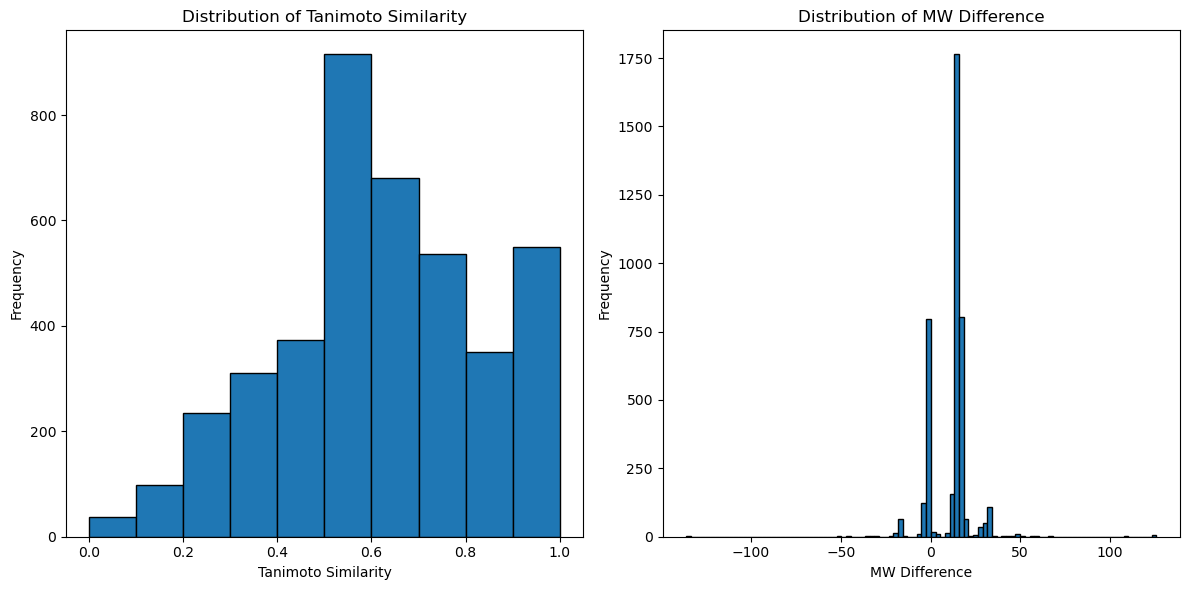

In [16]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, AllChem, Descriptors
from rdkit import DataStructs
import pandas as pd
import matplotlib.pyplot as plt

# source: https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html
def calculate_molecular_weight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return rdMolDescriptors.CalcExactMolWt(mol)

# source: https://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints
def tanimoto_similarity_morganfp(actual_smiles, predicted_smiles):
    # load molecules
    actual_mol = Chem.MolFromSmiles(actual_smiles)
    predicted_mol = Chem.MolFromSmiles(predicted_smiles)

    # generate Morgan fingerprints
    actual_mol_fp = AllChem.GetMorganFingerprintAsBitVect(actual_mol, 1, nBits=2048)
    predicted_mol_fp = AllChem.GetMorganFingerprintAsBitVect(predicted_mol, 1, nBits=2048)
    return DataStructs.TanimotoSimilarity(actual_mol_fp, predicted_mol_fp)


# calculate molecular weights
df['Actual MW'] = df['Actual SMILES'].apply(calculate_molecular_weight)
df['Predicted MW'] = df['Predicted SMILES'].apply(calculate_molecular_weight)

# calculate molecular weight difference
df['MW Difference'] = df['Actual MW'] - df['Predicted MW']

# calculate Tanimoto similarity using ECFP4
df['Tanimoto Similarity'] = df.apply(lambda row: tanimoto_similarity_morganfp(row['Actual SMILES'], row['Predicted SMILES']), axis=1)

# calculate mean values
mean_mw_difference = df['MW Difference'].mean()
mean_tanimoto_similarity = df['Tanimoto Similarity'].mean()

print(df[['Actual SMILES', 'Predicted SMILES', 'Actual MW', 'Predicted MW', 'MW Difference', 'Tanimoto Similarity']])
print(f"Mean MW Difference: {mean_mw_difference}")
print(f"Mean Tanimoto Similarity: {mean_tanimoto_similarity}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['Tanimoto Similarity'], bins=10, edgecolor='k')
plt.title('Distribution of Tanimoto Similarity')
plt.xlabel('Tanimoto Similarity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['MW Difference'], bins=100, edgecolor='k')
plt.title('Distribution of MW Difference')
plt.xlabel('MW Difference')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()